# Part 1 -  Collecting Data (Tweets from NY)

## Data - PreProcessing

Because we don't have property of gender in tweet structure, we needed to use the NLTK well known names to build our train dataset.

In order to extract as much as possible the correct gender, we filter all the names which can be use for female and for male.

In [5]:
#import nltk
#nltk.download()

from nltk.corpus import names

def GetWellDefineGenderFromName(first_name):
    first_name = first_name.lower()
    first_name = first_name.title()
    matchMale = False
    matchFemale = False
    if first_name in names.words("male.txt"):
        matchMale = True
    if first_name in names.words("female.txt"):
        matchFemale = True
    if matchMale and matchFemale:
        return None
        
    if matchMale:        
        return 'male'
        
    if matchFemale:
        return 'female'        
        
    return None

## Fetch raw data from tweeter

We choose that our population will be people from NY.

In order to get a meaningful tweets (means no commercial tweets from real people),we did the following:

1. Search for the words 'The', 'I', 'she', 'and'.
2. Ensure that the user language is english.
3. Ensure that the user location is NY.
4. Ensure that the name gender is well define as explaind above. 

In [6]:
#!conda install -c conda-forge tweepy=3.5.0
#!conda install -c malev gender_detector=0.1.0

import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import requests
import json

consumer_key = "03X3UAKKnYY9NxgFVjNffJnwT"
consumer_secret = "Y1uLISQfm1iBSf1My9YtBCgEj4qhYjlZJdCB3KcPmzASBxi4kb"
access_token = "857218802748190722-vDhmlyGncBlmu8HJY5JQlKHhQcFOcHA"
access_token_secret = "KcKRMci7NzEt2D7GpqdAJtTnAgCexHK9ZG67VsUNfA3hO"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

class StdOutListener(StreamListener):
    def on_data(self, data):            
        
        tweet = json.loads(data)
        
        if not tweet.get('user'):
            return True
        
        user = tweet['user']    
        
        if user['lang'] != 'en':
            return True
        
        if user['location'] is None:
            return True
        
        if 'New York' not in user['location'] and 'NY' not in user['location']:
            return True            
                
        gender = GetWellDefineGenderFromName(user['name'].encode('utf-8').decode().split()[0])
        
        if gender is None:            
            return True            
        
        # append the hourly tweet file
        with open('tweets.data', 'a+') as f:
            f.write(data)            
        
        return True
    
    def on_error(self, status):
        print('status: %s' % status)

streamListener = StdOutListener()
stream = Stream(auth, streamListener, timeout=30)


####
#call the below function when you want to fetch data
####

#Remove the comment below for running

'''
stream.filter(locations=[-74,40,-73,41], track=['The', 'I', 'she', 'and'])
'''

"\nstream.filter(locations=[-74,40,-73,41], track=['The', 'I', 'she', 'and'])\n"

## Data Cleaning - Define fucntions

### Decoding text to Ascii

Most of the NL Algorithms works with ASCII.

In [7]:
def UTFToAscii(string):
    return string.decode('ascii', 'ignore')

### Extract URLs, @user_reference, hashtags Count

In [8]:
from urllib.parse import urlparse

def ExtractReference(string):
    reference_count = 0
    hashtag_count = 0
    urls_count = 0
    for i in string.split():
        s, n, p, pa, q, f = urlparse(i)
        if s and n:
            urls_count = urls_count + 1
        elif i[:1] == '@':
            reference_count = reference_count + 1
        elif i[:1] == '#':
            hashtag_count = hashtag_count + 1            
        else:
            pass
    return reference_count, hashtag_count, urls_count

### Remove URLs, hashtags, @user_reference

In [9]:
import re

def RemoveNonWords(string):
    return re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", string)

### Handle Escaping Characters

In [10]:
from html.parser import HTMLParser

def RemoveEscaping(string):
    html_parser = HTMLParser()
    return html_parser.unescape(string)

### Convert to lowercase

In [11]:
def ToLowercase(string):
    return string.lower()

### Handle Apostrophe Lookup

In [12]:
import csv

def ReplaceApostrophe(string):
    appostophes_dict = None

    with open('appostophes.csv', mode='r') as infile:
        reader = csv.reader(infile)
        appostophes_dict = {rows[0]:rows[1] for rows in reader}
    
    words = string.split()
    reformed = [appostophes_dict[word] if word in appostophes_dict else word for word in words]
    string = " ".join(reformed)
    return string
    

### Clean RT

In [13]:
def RemoveRT(string):
    words = string.split()
    reformed = ['' if word in 'RT' else word for word in words]
    string = " ".join(reformed)
    return string

### Flat Lines

In [14]:
def FlatLines(string):
    lines = string.splitlines()
    string = " ".join(lines)
    return string

### Filter To First Line

In [15]:
def GetFirstLine(string):
    lines = string.splitlines()  
    return lines[0]

### Stemming

In [16]:
from nltk.stem import PorterStemmer

def Stemming(string):
    ps = PorterStemmer()
    
    words = string.split()
    words = map(ps.stem, words)   
    
    string = " ".join(words)
    return string

## Create dataframe from Json tweets file

In [17]:
import pandas as pd
import json

def IsEnglish(s):
    for i in s.split():
        if not i.isalpha():
            return False
    return True    

#read data from tweets.data

tweets_df = pd.DataFrame(columns=['id', 'text', 'reference_count', 'hashtag_count', 'urls_count' ,'name', 'gender'])
for line in open('tweets.data', 'rb'):        
    tweet_data = json.loads(line)
    tweet_fullname = tweet_data['user']['name'].encode().decode('utf-8')
    if IsEnglish(tweet_fullname) == False:
        continue

    tweet_text = tweet_data['text'].encode('utf-8')
    tweet_text = UTFToAscii(tweet_text)
    tweet_text = RemoveEscaping(tweet_text)    
    reference_count, hashtag_count, urls_count = ExtractReference(tweet_text)
    tweet_text = RemoveNonWords(tweet_text)
    tweet_text = RemoveRT(tweet_text)
    tweet_text = tweet_text.strip()
    tweet_text = ToLowercase(tweet_text)

    #filter all text that smaller then 2 words
    if len(tweet_text.split()) < 1:
        continue
    
    gender = GetWellDefineGenderFromName(tweet_fullname.split()[0])
    
    if gender is None:
        continue

    tweets_df.loc[len(tweets_df)]=[tweet_data['id_str'], tweet_text, reference_count, hashtag_count, urls_count, tweet_fullname, gender]


c:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


## Write Dataframe as CSV File

In [18]:
tweets_df.to_csv('tweets_df.csv')

## Data Exploration

First quick look in the data:

In [19]:
tweets_df.head(10)

,id,text,reference_count,hashtag_count,urls_count,name,gender
0,875088051977977856,how to give your employees the recognition the...,0,1,1,Guy Santeramo,male
1,875088067471831043,that was lovely thank you for sharing i too lo...,3,0,1,Alexa Harrison,female
2,875088072786022400,sling could a team made entirely of players wh...,0,0,1,Jay Zampi,male
3,875088110736089089,my fan theory is that your fan theory has noth...,1,0,0,Susana Polo,female
4,875088118990462976,psst youre not blessed youre just lucky as hel...,1,0,0,JEFF BRANDT,male
5,875088123126009857,drinking age should be lowered to 18,1,0,1,Cassie,female
6,875088132122836994,in the wake of alexandria and san francisco up...,1,3,0,Ralph,male
7,875088135889334273,if you say so princess im sure hell love to se...,1,0,1,Brad Gibson,male
8,875088148770033665,when she asks you what you bring to the table,1,0,1,Solomon Grundy,male
9,875088173939818497,finally biting the bullet and reserving hotel ...,0,1,0,Meg Roy,female


The texts are look good and also the names the and the gender.

In [20]:
tweets_df.describe(include='all')

,id,text,reference_count,hashtag_count,urls_count,name,gender
count,11889,11889,11889,11889,11889,11889,11889
unique,11888,11133,11,13,4,7941,2
top,879427176537489409,rowling 20 years ago today a world that i had ...,1,0,0,Joe Dicandia,male
freq,2,21,6430,9672,6159,39,6530


In [21]:
tweets_df['gender'] = tweets_df['gender'].astype('category')
tweets_df.gender.value_counts()

male      6530
female    5359
Name: gender, dtype: int64

We have 4133 samples.

female: ~0.39
male:~0.61

Types:

In [22]:
tweets_df.dtypes

id                   object
text                 object
reference_count      object
hashtag_count        object
urls_count           object
name                 object
gender             category
dtype: object

Should not be missing values:

### Male ,Female Ratio

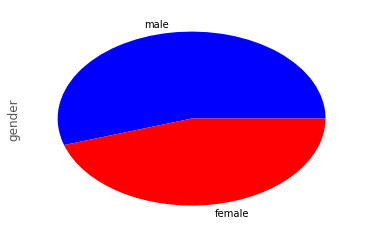

In [23]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

plt.figure();

tweets_df.gender.value_counts().plot(kind='pie', colors=['blue','red'])

## Tweet Reference, Hashtag, URL Count By Gender


Let's explore the information which we extract from the original tweet text.


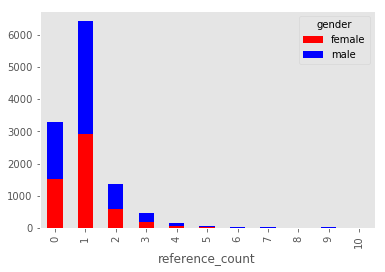

In [24]:
var = pd.crosstab(tweets_df['reference_count'], tweets_df['gender'])
var.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

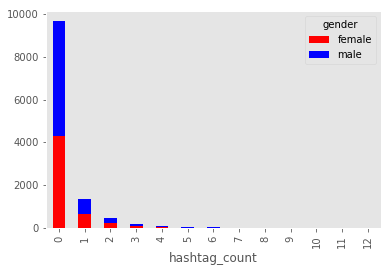

In [25]:
var = pd.crosstab(tweets_df['hashtag_count'], tweets_df['gender'])
var.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

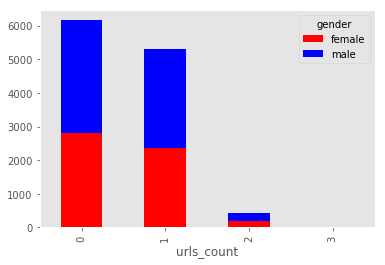

In [26]:
var = pd.crosstab(tweets_df['urls_count'], tweets_df['gender'])
var.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

We can see from above that these features not give us an additional information. (the male/female ratio remains almost the same for each value).

## Backup Dataframe to Pickle file

In [27]:
tweets_df.to_pickle('DataFramePickle')

# Part 2 - Train Classifier For Gender

## 2.1 Try 1 - DT,  Naive bayes,  SVM linear Classifiers based on TF-IDF features

### Algorithms Description

TF-IDF - In information retrieval, tf–idf, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document, but is often offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. Nowadays, tf-idf is one of the most popular term-weighting schemes. For instance, 83% of text-based recommender systems in the domain of digital libraries use tf-idf
(https://en.wikipedia.org/wiki/Tf%E2%80%93idf)


DT - A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm.
(https://en.wikipedia.org/wiki/Decision_tree)

Naive bayes - It is a classification technique based on Bayes' Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.
(https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

SVM linear - In machine learning, support vector machines (SVMs, also support vector networks[1]) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier (although methods such as Platt scaling exist to use SVM in a probabilistic classification setting). An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on on which side of the gap they fall. (https://en.wikipedia.org/wiki/Support_vector_machine)

## Global Configuration

In [28]:
import os

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
write_path = 'Models\\'

ensure_dir(write_path)

## Function: Top features for model

In [29]:
def print_topFeatures( classifier,stri,numOfFeatures):
    """Prints features with the highest coefficient values, per class"""
    dfSignificantFeatures = pd.DataFrame()
    class_labels = classifier.classes_
    for i, class_label in enumerate(class_labels):
        if len(class_labels)>2:
            coef = classifier.coef_[i]
        else:
            coef = classifier.feature_log_prob_[i]

        top20 = np.argsort(coef)[-40:]
        toList = (" %s" % (",".join(feature_names[j] for j in top20)))
        list = toList.split(',')
        dfSignificantFeatures[class_label.upper()] = list[::-1]
        
    dfSignificantFeatures.to_csv(write_path +'_best40Features_allWords_'+str(numOfFeatures)+stri+'.csv', mode='a', sep=',')

## Function: Split the data to train and test sets

In [63]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_test_set(texts, gender, RemoveStopWords, f, t, analyzer, binary):

    corpus = np.array(texts.values).tolist()
    target = np.array(gender.values)
    #tf-idf vectorizer is set to count word occurances and normalize. NOT TF-IDF
    if RemoveStopWords:
        vectorizer = TfidfVectorizer(stop_words='english',analyzer=analyzer,use_idf=False, ngram_range=(f,t),binary=binary)
    else: #only SW
        vectorizer = TfidfVectorizer(analyzer=analyzer, use_idf=False, ngram_range=(f,t),binary=binary,norm='l1')
    
    X = vectorizer.fit_transform(corpus)
    global feature_names
    feature_names = vectorizer.get_feature_names()

    return X, target, feature_names#

## Function: Plots a confusion matrix

In [31]:
import matplotlib.pyplot as plt

def plot_cnf_matrix(cms, classes, model_name, numOfFeatures):
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(cms), cmap=plt.cm.jet, interpolation='nearest')
    
    width, height = cms.shape
    
    try: 
        xrange 
    except NameError: 
        xrange = range
    
    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(cms[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    
    cb = fig.colorbar(res)
    plt.xticks(range(width), classes)
    plt.yticks(range(height), classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix " + str(numOfFeatures) + ' ' + model_name)
    plt.show()

## Function: Trains the model k-fold times and returns total accuracy

In [66]:
from sklearn.metrics import confusion_matrix

def train_model_kf_cv(model, kf, data, target, numFolds, model_name, ngram):
    cm = []
    error = []
    for train_indices, test_indices in kf:
        # Get the dataset; this is the way to access values in a pandas DataFrame
        train_X = data[train_indices, :]
        train_Y = target[train_indices]
        test_X = data[test_indices, :]
        test_Y = target[test_indices]
        # Train the model
        model.fit(train_X, train_Y)
        predictions = model.predict(test_X)
        # Evaluate the model
        ###fpr, tpr, _ = roc_curve(test_Y, predictions)
        classes = model.classes_                
        cm.append(confusion_matrix(test_Y, predictions, labels=classes))
        ###total += auc(fpr, tpr)
        error.append(model.score(test_X, test_Y))
    accuracy = np.mean(error)
    for i in range(0,9):
        cms = np.mean(cm, axis=0)
    plot_cnf_matrix(cms, classes, model_name,ngram)
    ###auc = total / numFolds
    ###print "AUC of {0}: {1}".format(Model.__name__, accuracy)
    return accuracy

## Function to balanced data (50% Male, 50% Female)

In [5]:
from numpy import unique
from numpy import random 
import operator

def balanced_sample_maker(X, y, random_seed=None):
    uniq_levels = unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}    

    if not random_seed is None:
        random.seed(random_seed)
    
    min_level_index = None
    if uniq_counts[uniq_levels[0]] < uniq_counts[uniq_levels[1]]:
        min_level_index = 0
    else:
        min_level_index = 1
    
    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx

    # oversampling on observations of positive label    
    sample_size = uniq_counts[uniq_levels[min_level_index]]
    over_sample_idx = random.choice(groupby_levels[uniq_levels[1-min_level_index]], size=sample_size, replace=True).tolist()
    balanced_copy_idx = groupby_levels[uniq_levels[min_level_index]] + over_sample_idx
    random.shuffle(balanced_copy_idx)

    return X[balanced_copy_idx], y[balanced_copy_idx]

## Function: Plot Learning Curve

In [69]:
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, \
                        ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")    

    return plt

## Function: Classify our data

df - Data

RemoveStopWords - If true remove stopping words

Analyzer - Specify 'word'/'char'- the minimum token unit

ngrams - the size of n-gram

In [70]:
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeClassifier
import pickle
import sklearn.naive_bayes as nb
import sklearn
from sklearn import tree
from sklearn import svm

def Classify(df, RemoveStopWords, analyzer, ngrams):
    a = {'Classifer': pd.Series(index=['DT', 'Naive bayes', 'SVM linear' ]),}
    scoreTable = pd.DataFrame(a)

    scoreTable.__delitem__('Classifer')

    dfReduced = df.copy(deep=True)
    texts, labels = balanced_sample_maker(dfReduced['text'],dfReduced['gender'])    

    #if we want to check for several x top featurs
    for ngram in ngrams:
        nfolds=5
        accuracies = []
        data, target, feat_names = extract_test_set(texts, labels, RemoveStopWords, 1,ngram, analyzer, False)
        kf = KFold(data.shape[0], n_folds = nfolds, shuffle = True, random_state = 1)        

        dtree = DecisionTreeClassifier(random_state=0, max_depth=50)
        plot_learning_curve(dtree, "DT", data, target, cv=kf, n_jobs=4)
        acc = train_model_kf_cv(dtree, kf, data, target, nfolds, 'DT',ngram)
        accuracies.append(acc)
        #pickle.dump(dtree, open(write_path+"dtree"+str(numOfFeatures), 'wb'))

        bayes = nb.MultinomialNB()
        plot_learning_curve(bayes, "Bayes", data, target, cv=kf, n_jobs=4)
        acc = train_model_kf_cv(bayes, kf, data, target, nfolds, 'Naive bayes',ngram)
        accuracies.append(acc)
        #pickle.dump(bayes, open(write_path+"bayes"+str(numOfFeatures), 'wb'))

        #print_topFeatures(bayes,'bayes',numOfFeatures)

        clf = sklearn.svm.SVC(decision_function_shape='ovo',kernel='linear')
        plot_learning_curve(clf, "SVM", data, target, cv=kf, n_jobs=4)
        acc = train_model_kf_cv(clf, kf, data, target, nfolds, 'SVM linear',ngram)
        accuracies.append(acc)
        #pickle.dump(clf, open(write_path+"svm"+str(numOfFeatures), 'wb'))
        scoreTable[ngram] = accuracies
    return scoreTable

## Run classifiers with removing stopping words

In [2]:
import pandas as pd

tweets_df = pd.read_pickle(r'DataFramePickle')

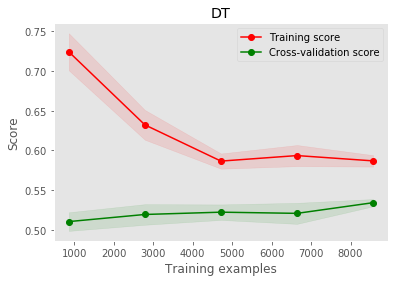

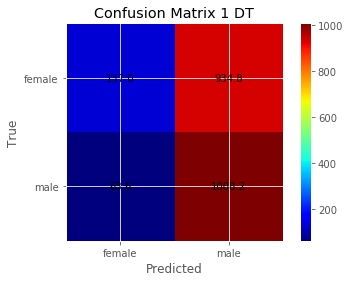

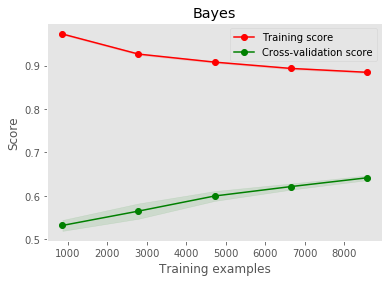

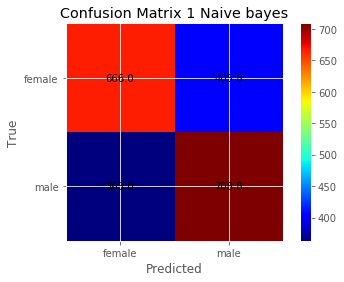

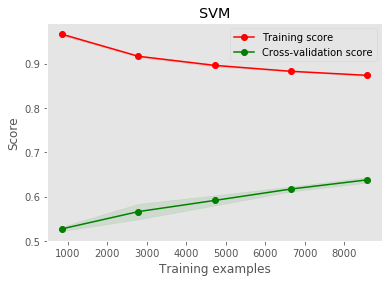

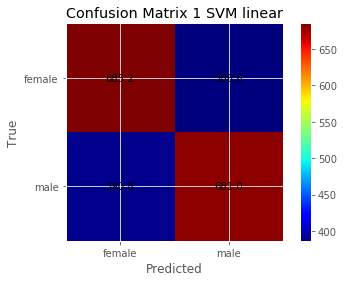

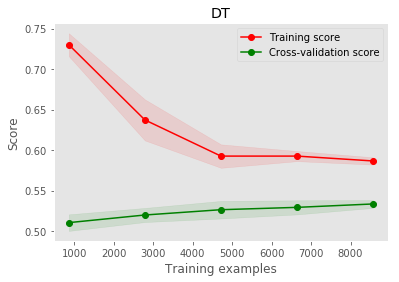

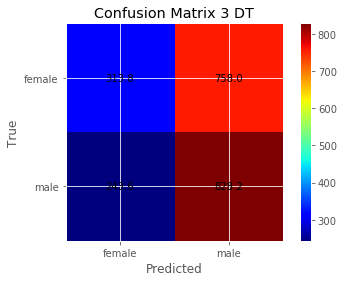

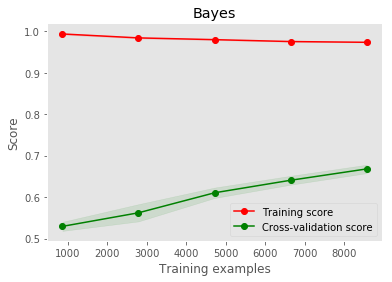

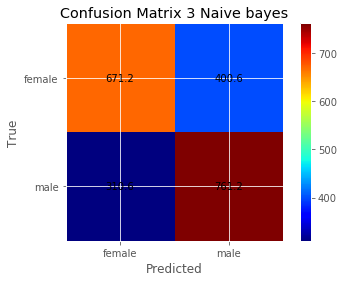

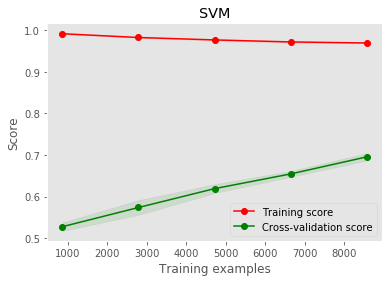

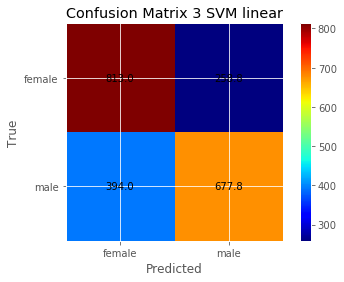

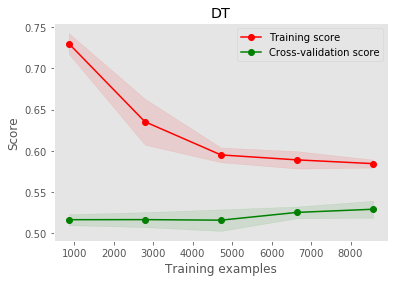

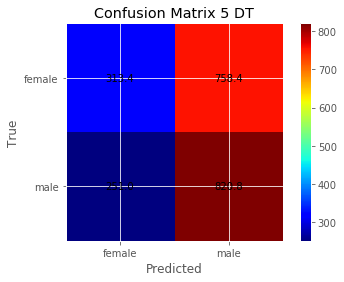

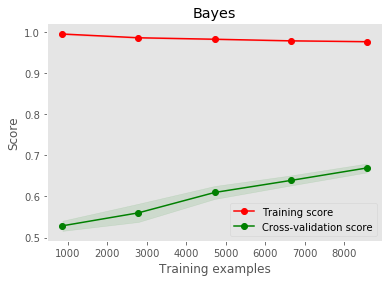

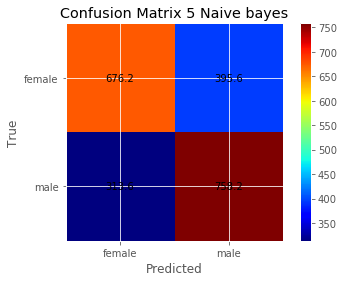

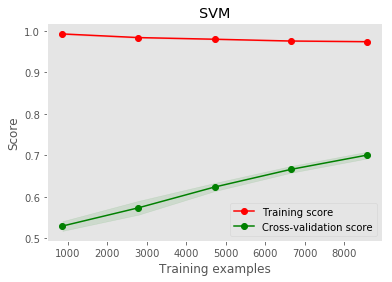

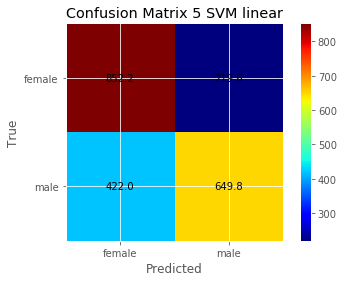

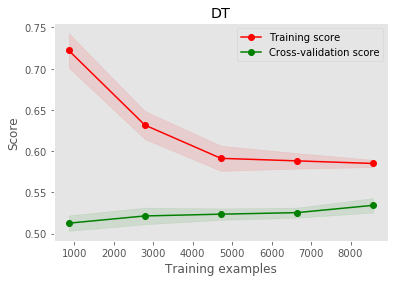

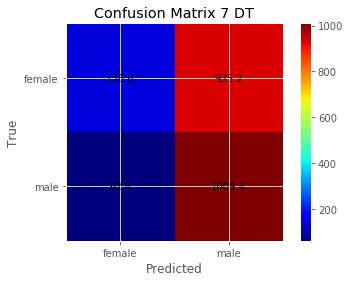

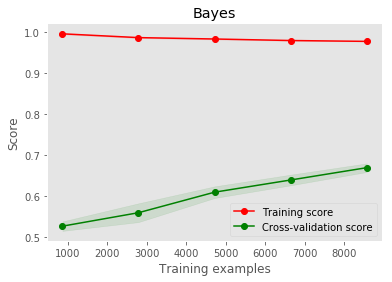

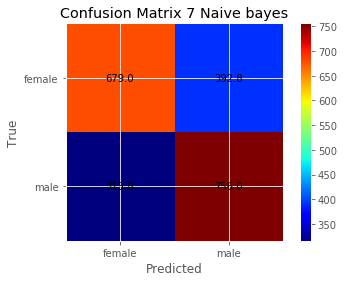

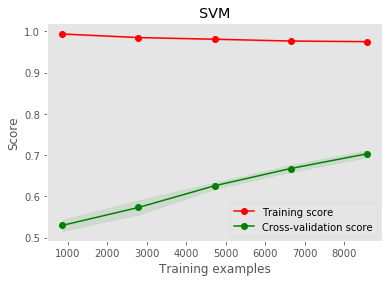

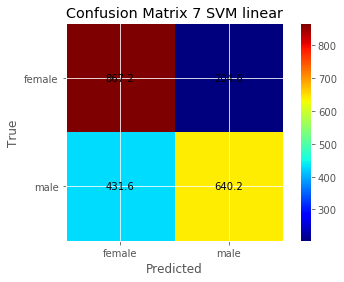

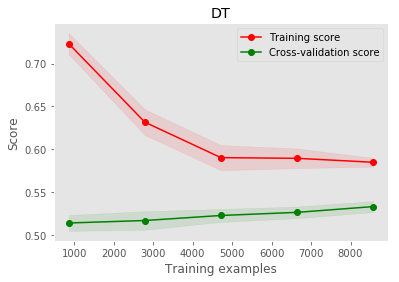

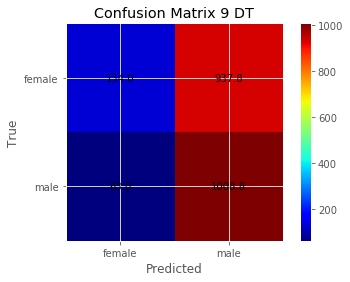

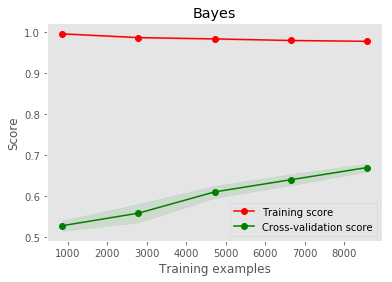

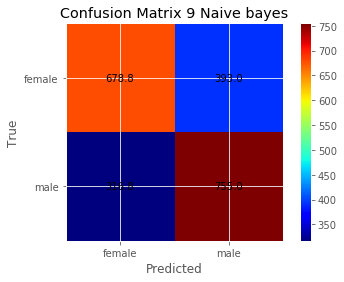

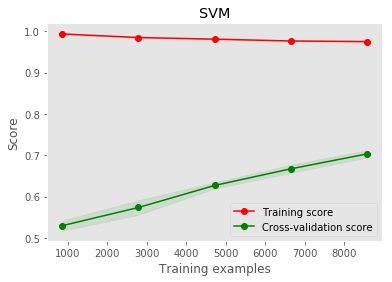

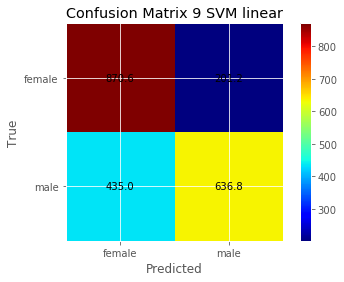

In [73]:
scoreTable = Classify(tweets_df, True, 'word', [1, 3, 5, 7 ,9])

## Score Table

In [77]:
scoreTable

,1,3,5,7,9
DT,0.534241,0.532748,0.529110,0.534614,0.533121
Naive bayes,0.641351,0.668221,0.669154,0.669434,0.668874
SVM linear,0.637339,0.695466,0.700691,0.703211,0.703210


## Run classifiers without  to remove stopping words

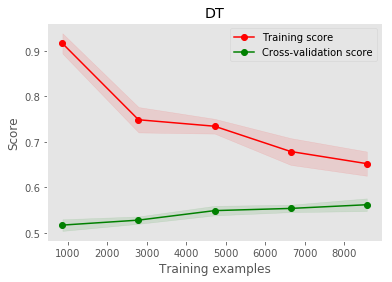

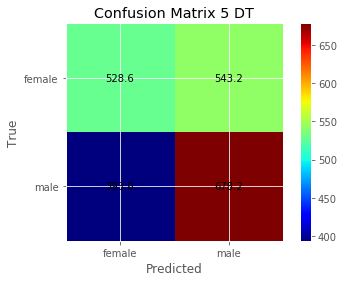

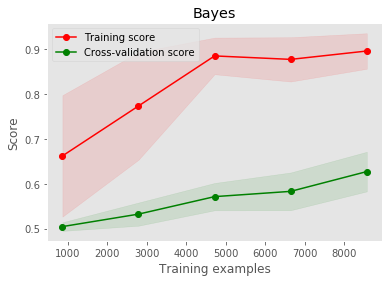

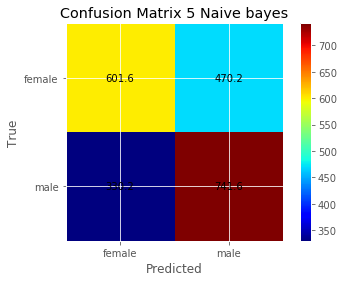

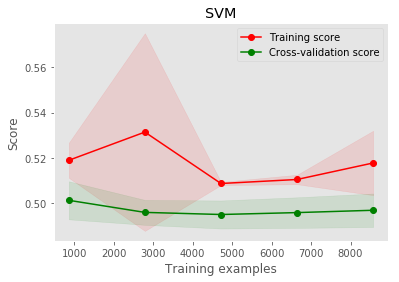

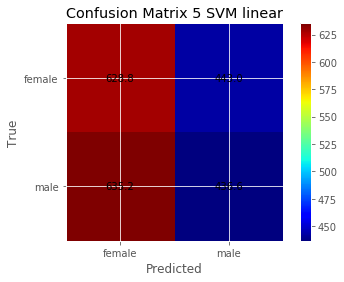

In [78]:
scoreTable = Classify(tweets_df, False, 'word', [5])

## Conclusions until now

1. SVM algorithm given us the best results. 
2. We can get better results if we will continue to increase the dataset size.
3. The best result given when we didn't restrict the maximum number of words represents as vector
4. When n-gram > 5 the result are not getting better. (let's continue with n-gram 5)
5. Without to remove stopping words the results are not good(compare to with removing stopping words)

## Try 2 - CNN using Keras package

## Algorithm Description

Keras - Keras is a high-level neural networks API, written in Python and capable of running on top of either TensorFlow, CNTK or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

GloVe- GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

The inspiration of the strcture comes from and article of Aric Bartle, Jim Zheng - Gender Classification with Deep Learning. (https://cs224d.stanford.edu/reports/BartleAric.pdf)

The strcture we built is:

1. Sequence of 20 words
2. Embedding Layer of 20 vectors with GloVe dictionary 300 dimension.
3. Convolution Layer of 3 words with 300 dimension.
4. Max Pooling Layer in size of 3 with 3000 dimension.
5. Flattern Layer.
6. Dense to 2 classes (male, female).

The intuition behind is to let the machine find the combination of the three words that emphasise the difference between male tweet to female tweet.

## Function: Testing Theano working with GPU

In [ ]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time
 
vlen = 10 * 30 * 768 # 10 x #cores x # threads per core
iters = 1000
 
rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
 r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
 print('Used the cpu')
else:
 print('Used the gpu')

## Read dictionary of words (GloVe package)

In [8]:
import os
import numpy
import numpy as np

GLOVE_DIR = '.\\Glove\\'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
from keras.layers import Input, Embedding, LSTM, Dense, GRU, Activation, SimpleRNN
from keras.layers.wrappers import Bidirectional
from keras.models import Sequential
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Flatten
from keras.preprocessing import sequence
import numpy
from sklearn.cross_validation import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import roc_auc_score

EMBEDDING_DIM = 300

# fix random seed for reproducibility
numpy.random.seed(7)

def PlotLearningCurve(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def TrainKeras(df):
    texts, labels = balanced_sample_maker(tweets_df['text'],tweets_df['gender'])
        
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))    

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)    

    labels_unique, labels_inverse = np.unique(labels, return_inverse=True)
    print('Found %s unique labels.' % len(labels_unique))
    
    labels_binary = keras.utils.to_categorical(labels_inverse)
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels_binary.shape)

    # split the data into a training set and a validation set
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels_binary = labels_binary[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

    x_train = data[:-nb_validation_samples]
    y_train = labels_binary[:-nb_validation_samples]
    x_test = data[-nb_validation_samples:]
    y_test = labels_binary[-nb_validation_samples:]

    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():        
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                        EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False)

    main_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='main_input')
    embedding_out = embedding_layer(main_input)    
    word_context_out1 = Conv1D(EMBEDDING_DIM, 3, activation='relu')(embedding_out)    
    max_pooling_out = MaxPooling1D(5)(word_context_out1)
    
    flat_out = Flatten()(max_pooling_out)    
    main_output = Dense(len(labels_unique), activation='softmax')(flat_out)
    model = Model(inputs=[main_input], outputs=[main_output])
    
    model.compile(loss='categorical_crossentropy',
          optimizer='rmsprop',
          metrics=['acc'])

    print(model.summary())
    
    # happy learning!
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
      epochs=10, batch_size=128)
    
    PlotLearningCurve(history)

    scores = model.evaluate(x_test, y_test, verbose=0)    

    print("Accuracy: %.2f%%" % (scores[1]*100))
    
            

# Count the number of unique words

In [107]:
words = set()

for index in tweets_df.index:
    sequences = tweets_df.iloc[index]['text'].split()
    for word in sequences:
        words.add(word)

len(words)

21593

Found 18080 unique tokens.
Found 2 unique labels.
Shape of data tensor: (10718, 20)
Shape of label tensor: (10718, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 20)                0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 20, 300)           5424300   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 18, 300)           270300    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 3, 300)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 1802      
Total params: 5,696,402


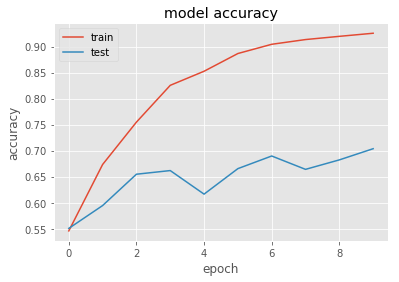

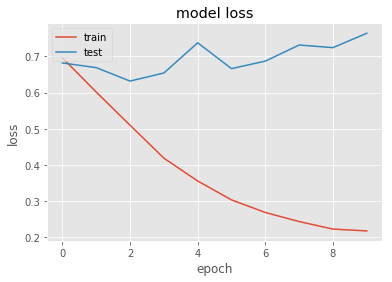

Accuracy: 70.37%


In [111]:
MAX_NB_WORDS = 5000
VALIDATION_SPLIT = 0.2
MAX_SEQUENCE_LENGTH = 20

TrainKeras(tweets_df)

## Conclusions until now

1. 5000 maximum number of words choosen because it give us the best results.
2. The sequence length is very dominant parameter, 20 gives the best result.
3. The learning is super fast compare to SVM classifier.
4. I recognize in deep learning a lot of potential, but it give me the impression that it more sensitive in manner of configuration and data, the conventional algorithm SVM seems to be more stable.

We choose to continue with n-gram SVM.